In [7]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import random

# load the dataset
X, y = load_digits(return_X_y=True)


Preliminary data analysis:

In [8]:
print(f"Dataset shape: {X.shape}")

n_samples, n_features = X.shape
print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")

print(f"Feature value range: {np.min(X)} to {np.max(X)}")

classes = set(y)
print(f"Classes: {classes}")

print(f"Scale of the dataset: {np.mean(X)}")

print(f"Variance of the dataset: {np.var(X)}")

Dataset shape: (1797, 64)
Number of samples: 1797
Number of features: 64
Feature value range: 0.0 to 16.0
Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Scale of the dataset: 4.884164579855314
Variance of the dataset: 36.20173240585726


Evaluating the accuracy of different train-test ratios:

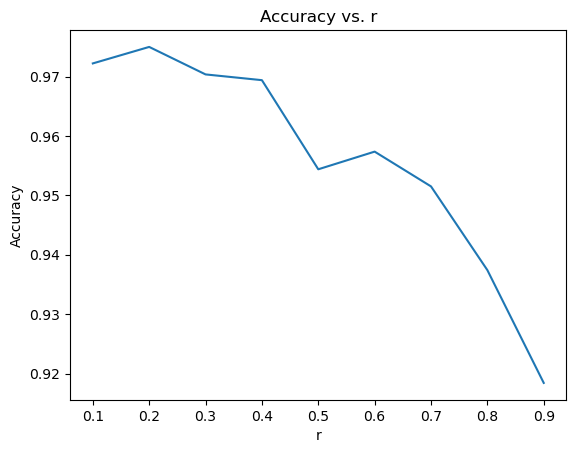

In [9]:
model = LogisticRegression()

ratios = np.arange(start=0.1, stop=1, step=0.1)
accs = []

# Instantiate a StandardScaler object
scaler = StandardScaler()

# Scale the features in your data using the fit_transform() method
X_scaled = scaler.fit_transform(X)

for ratio in ratios:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=ratio)
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    acc = accuracy_score(y_test, cloned_model.predict(X_test))
    accs.append(acc)
#     print(acc)

# Plot the accuracy of each r using pyplot
plt.plot(ratios, accs)

# Set the labels for the x and y axes and the title of the plot
plt.xlabel('r')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. r')

# Display the plot
plt.show()


Creating an unbalanced subset of the dataset:

In [10]:
X_indexes = range(X.shape[0])
unbalanced_indexes = random.sample(X_indexes, 1000)

X_unbalanced = X[unbalanced_indexes]
y_unbalanced = y[unbalanced_indexes]

y_frequencies = {d:0 for d in classes}

for i in y_unbalanced:
    y_frequencies[i] += 1
    
y_min_frequency = min(y_frequencies.values())

print(f"y frequencies: {y_frequencies}")
print(f"y min frequency: {y_min_frequency}")
    

y frequencies: {0: 99, 1: 96, 2: 109, 3: 99, 4: 93, 5: 102, 6: 106, 7: 96, 8: 96, 9: 104}
y min frequency: 93


Creating a balanced subset of the unbalanced dataset:

In [13]:
X_balanced = np.empty((0, X_unbalanced.shape[1]))
y_balanced = np.empty(0)

for d in classes:
    # find the rows in X_unbalanced that correspond to the digit d ({0, 1, ..., 9})
    X_d = X_unbalanced[y_unbalanced == d]
    
    # randomly sample y_min_frequency data points from X_d
    indexes = random.sample(range(X_d.shape[0]), y_min_frequency)
    X_batch = X_d[indexes]
    
    y_batch = np.full((y_min_frequency, ), d)
    
    X_balanced = np.vstack((X_balanced, X_batch))
    y_balanced = np.append(y_balanced, y_batch)
    
# check that the new dataset is balanced

y_frequencies = {d:0 for d in classes}

for i in y_balanced:
    y_frequencies[i] += 1
    
print(f"y_balanced frequencies: {y_frequencies}")

y_balanced frequencies: {0: 93, 1: 93, 2: 93, 3: 93, 4: 93, 5: 93, 6: 93, 7: 93, 8: 93, 9: 93}


Evaluating the accuracy of different train-test ratios on the balanced subset:

In [ ]:
# Instantiate a StandardScaler object
scaler = StandardScaler()

# Scale the features in your data using the fit_transform() method
X_scaled = scaler.fit_transform(X_balanced)

# clear accs
accs = []

for ratio in ratios:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=ratio)
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    acc = accuracy_score(y_test, cloned_model.predict(X_test))
    accs.append(acc)
    print(acc)
    
# Plot the accuracy of each r using pyplot
plt.plot(ratios, accs)

# Set the labels for the x and y axes and the title of the plot
plt.xlabel('r')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. r')

# Display the plot
plt.show()